### generating then ranking audio
- load the CNN model (or some other ranker) from feature_extraction 
- genereate parameters and its corresponding audio "randomly"
- rank the parameters using the ranker
- save the parameters that made the sound along with the rankings to some dataframe

In [204]:
import numpy as np
import pandas as pd
import torch
import torchvision
from feature_extraction import CNN_utils
import matplotlib.pyplot as plt
import librosa
# generation imports
from pippi.soundbuffer import SoundBuffer
from pippi import dsp,fx
import helpers as hp

import param_generation as pg
import _pickle as pickle
from IPython.display import Audio
from feature_extraction import mir_utils as mu
###
import torch.utils.data as utils
import torchvision.transforms as transforms
from PIL import Image
###

sr=44100
stack_size=3
BATCH_SIZE=1
classes=['clap', 'guitar',
         'hat', 'kick', 'noise',
         'piano', 'rim', 'shake', 'snare', 'synth','tom', 'voc']
cDict={v:i for i,v in enumerate(classes)}

# function to show an image
def imshow(img):
    img = img      # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    

In [27]:
#setup CNN
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device="cpu"
s=torch.load("feature_extraction/models/model-4-18.states")
cnn = CNN_utils.CNN_net()
cnn.load_state_dict(s["model_state_dict"])
cnn.to(device)
pass

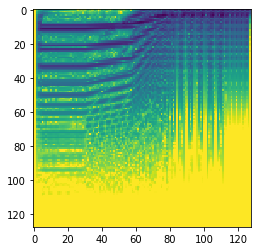

In [29]:
# example of how to make an audio stack, get audio, make (mel_spectrum) image for that audio
out,params=hp.stackMaker(stack_size)
a=hp.memToAud(out)
# get the image for that audio
im=mu.audToImage(a,128)
im=-1*librosa.util.normalize(im)
plt.imshow(im)
Audio(a,rate=sr, autoplay=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


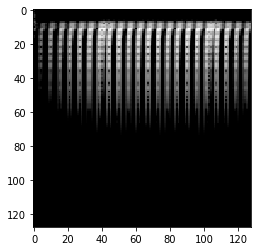

[('synth', 0.19172847), ('noise', 0.12733813), ('voc', 0.120280296), ('tom', 0.11374565), ('guitar', 0.10715758), ('hat', 0.10196111), ('piano', 0.073887), ('kick', 0.06526031), ('snare', 0.039395176), ('clap', 0.038530897), ('shake', 0.020715354), ('rim', 0.0)]


In [400]:
# %%time
# make a row of data and show what's going on
def makeRowSlow():
    ## function that makes a row of parameters and the scores for the parameters 
    ## this row can then be added to a dataframe/csv file etc
    out,params=hp.stackMaker(1)
    a=hp.memToAud(out)
    # get the image for that audio
    im=mu.audToImage(a,128)
    z=librosa.util.normalize(im)
    t= transforms.Compose(
        [
        transforms.ToTensor(), 
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    #normalize array->pilform ->apply transoforms,
    z=(((z - z.min()) / (z.max() - z.min())) * 255.9).astype(np.uint8)
    zi=Image.fromarray(z)
    z=t(zi)
    images=z.reshape([1,1,128,128])

    dimg=images.to(device)
    outputs=cnn(dimg)
    _, predicted = torch.max(outputs, 1)
    

    o=outputs.cpu().detach().numpy()[0]
    o_norm=o-min(o)
    o_norm=o_norm/sum(o_norm)
    rowDict=dict(zip(classes,o_norm))
    imshow(torchvision.utils.make_grid(images))
    print(sorted(rowDict.items(), key=lambda x: x[1],reverse=True))

    return a,rowDict,params
a,rowDict,params=makeRowSlow()

Audio(a,rate=sr, autoplay=True)

#### here's what a row looks like, next print rows like this without the headers so we can redirect it to a csv/text file

In [399]:
pd.concat([pd.DataFrame.from_dict([rowDict]),hp.paramToDF(params)],axis=1)

,clap,guitar,hat,kick,noise,piano,rim,shake,snare,synth,...,bpCutLow_0,bpCutHigh_0,bpOrder_0,length_0,start_0,pitch0_0,pitch1_0,pitch2_0,pitch3_0,pitch4_0
0,0.0,0.014783,0.139714,0.126462,0.098695,0.072253,0.029691,0.083717,0.084466,0.168945,...,3717.063955,9031.651619,2,0.816497,0.040779,15000,15000,15000,15000,15000


In [784]:
### do the last 2 columns but no bellls or whistles 
def makeRows():

    ## function that makes a row of parameters and the scores for the parameters 
    ## this row can then be added to a dataframe/csv file etc
    out,params=hp.stackMaker(1)
    a=hp.memToAud(out)
    
    # get the image for that audio
    
    try:
        im=mu.audToImage(a,128)
    except:
        return "fail"
    z=librosa.util.normalize(im)
    t= transforms.Compose(
        [
        transforms.ToTensor(), 
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    #normalize array->pilform ->apply transoforms,
    z=(((z - z.min()) / (z.max() - z.min())) * 255.9).astype(np.uint8)
    zi=Image.fromarray(z)
    z=t(zi)
    images=z.reshape([1,1,128,128])

    dimg=images.to(device)
    outputs=cnn(dimg)
    _, predicted = torch.max(outputs, 1)

    o=outputs.cpu().detach().numpy()[0]
    o_norm=o-min(o)
    o_norm=o_norm/sum(o_norm)
    rowDict=dict(zip(classes,o_norm))
    
    df=pd.concat([pd.DataFrame.from_dict([rowDict]),hp.paramToDF(params)],axis=1)    
    x=df.to_string(header=False,
                  index=False,
                  index_names=False).split('\n')
    vals = [','.join(ele.split()) for ele in x]
    return vals

while (1):
    print(makeRows())

['0.030534,0.081382,0.073053,0.094352,0.107781,0.082814,0.097669,0.076797,0.0,0.134258,0.098422,0.122938,sine,0,2,2,1,1,5,34.056677,1,0,0.8,11639.363139,15000.0,8,0.632456,0.122515,15000,15000,15000,15000,15000']
['0.0,0.032911,0.121822,0.119176,0.112236,0.016722,0.039911,0.131517,0.031549,0.211453,0.089415,0.093288,saw,0,0,0,1,0,5,5438.048732,1,8,0.5,9031.651619,15000.0,16,0.774597,0.025045,5438,5438,5496,6939,15000']
['0.0,0.099748,0.062004,0.144719,0.116688,0.090035,0.035875,0.002383,0.046971,0.171416,0.111726,0.118435,saw,0,3,3,0,3,5,228.253572,1,0,0.8,177.115081,333.934003,16,0.516398,0.107467,15000,15000,15000,15000,15000']
['0.0,0.069217,0.117907,0.084766,0.103752,0.003485,0.049793,0.123384,0.059729,0.185703,0.051664,0.1506,sine,0,0,2,2,2,5,7008.178196,1,0,1.0,3717.063955,7955.842127,8,0.774597,0.150269,15000,15000,15000,15000,15000']
['0.040474,0.037224,0.130529,0.108481,0.095823,0.0,0.045097,0.09613,0.085393,0.181512,0.101876,0.077461,square,0,1,3,1,1,5,379.089421,-1,8,0.5,223

KeyboardInterrupt: 

In [732]:

with Pool(5) as p:
    print(p.map(f, [1, 2, 3]))

h
h
h


Process ForkPoolWorker-178:
Process ForkPoolWorker-176:
Process ForkPoolWorker-177:
Process ForkPoolWorker-179:


[1, 4, 9]


Process ForkPoolWorker-180:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._targ

KeyboardInterrupt: 

'cpu'